<a href="https://colab.research.google.com/github/gregd190/Generative-Adversarial-Network---MNIST-Dataset-Drawing-Digits-/blob/master/Part%20I%20-%20Fully-Connected%20Network%20-%20Drawing%20a%20Single%20Digit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generative Adversarial Network - Drawing a Single Digit
This notebook will build the most basic GAN possible. It will use 2 simple, fully-connected networks to learn how to draw a single digit ('3') from the MNIST dataset. 

First, get the dataset from the repository:

In [1]:
#Download the dataset from github

!git clone https://github.com/gregd190/Image-Classification---MNIST-Dataset---NN-Solutions
!cp -r Image-Classification---MNIST-Dataset---NN-Solutions/. /content/


Cloning into 'Image-Classification---MNIST-Dataset---NN-Solutions'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 4), reused 12 (delta 3), pack-reused 0
Unpacking objects: 100% (14/14), done.


Import the necessary libraries:

In [2]:
#Import the necessary libraries

import numpy as np
import keras
import struct
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, LeakyReLU
from keras import optimizers


Using TensorFlow backend.


Preprocess the data:

In [0]:
# The MNIST data is provided in a file format that needs to be read before the data can be fed to the neural network. 
def read_data(image_filename, label_filename):
    
    #Create arrays to store labels and pixel data
    label_array = []
    image_array = []
    
    # Load everything in some numpy arrays
    with open(label_filename, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(image_filename, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    for i in range(len(lbl)):
        label_array.append(lbl[i])
        image_array.append(img[i])
    
    #Convert arrays to np.arrays
    image_array = np.array(image_array)
    label_array = np.array(label_array)
    

    #Normalise image data to between 0 and 1
    image_array = image_array/255.
    
    return(image_array, label_array)
  


Check that the data arrays look correct:

In [4]:
train_images, train_labels = read_data('train-images.idx3-ubyte', 'train-labels.idx1-ubyte')
print('Shape of train_labels = ',np.shape(train_labels))
print('Shape of train_images = ', np.shape(train_images))


Shape of train_labels =  (60000,)
Shape of train_images =  (60000, 28, 28)


Find the array indexes of the number 3

In [5]:
threes_index = np.nonzero(train_labels==3)

#Test they are all 7's
print(train_labels[threes_index])

threes = train_images[threes_index]
np.shape(threes)




[3 3 3 ... 3 3 3]


(6131, 28, 28)

We have a training set of 6265 images of the digit 7.


Let's build the networks. 

In [6]:
def build_discriminator_model(input_shape, num_output_nodes, lr, size):
    
    model = Sequential()
    
    model.add(Dense(size[0], input_shape = input_shape))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    
    for i in range(1,len(size)):
        model.add(Dense(size[i]))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.3))
    
    model.add(Dense(num_output_nodes, activation = 'sigmoid')) 
    
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss = 'binary_crossentropy', optimizer = adam)
    
    model.summary()
    
    return model

def build_generator_model(input_shape, num_output_nodes, lr, size):
    
    model = Sequential()
    
    model.add(Dense(size[0], input_shape = input_shape, activation = 'relu'))
    
    for i in range(1,len(size)):
        model.add(Dense(size[i]))
        model.add(LeakyReLU(0.2))
    
    model.add(Dense(num_output_nodes, activation = 'tanh')) 
    
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss = 'binary_crossentropy', optimizer = adam)
    
    model.summary()
    
    return model

#Discriminator takes input of 784 pixels  
discriminator = build_discriminator_model((784,), 1, 1e-5, [1024,512,256])

#Generator will take 100 inputs of random noise
generator = build_generator_model((100,), 784, 1e-5, [256,512,1024]) 



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
__________

In [0]:
def build_gan_model(discriminator, generator):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(100,))
    # the output of the generator (an image)
    generated_image = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(generated_image)
    gan = Model(inputs=gan_input, outputs=gan_output)
    adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999)
    gan.compile(loss='binary_crossentropy', optimizer=adam)
    return gan

gan_model = build_gan_model(discriminator, generator) 

We need a way of determining whether to feed an image from the training set, or an image from the generator to the discriminator. We'll create a function that decides based on a 50:50 split

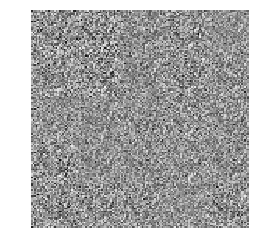

()

In [8]:
def plot_generated_images(images_high, images_wide):
   
  image = np.zeros((images_high*28,images_wide*28))
    
  for h in range(images_high):
    for w in range(images_wide):
      noise = np.array([np.random.normal(0,1,100)])
      generated_image = generator.predict(noise)
      generated_image = generated_image.reshape(28, 28)
      image[h*28:(h+1)*28, w*28:(w+1)*28] = generated_image
  
  
  plt.imshow(image, interpolation='nearest')
  plt.axis('off')
  plt.show()
  return()
  
#Test it - At this stage it should just be random pixels
plot_generated_images(5,5)

In [0]:
#Will return either a randomly generated image, or an image from the training set, plus either a 0 or 1, indicating whether the image is real(1) or generated(0)

def pick_image():
  if np.random.uniform() < 0.5:
    a = np.random.randint(0,len(threes))
    
    #print('TRUE IMAGE', np.shape(np.ndarray.flatten(threes[a])))
    return(np.reshape(threes[a],(1,784)),np.random.uniform(0.9,1))
  else:
    random_inputs = np.array([np.random.uniform(0,1,100)])
    generated_image = generator.predict(random_inputs)      
    #print('FAKE IMAGE', np.shape(generated_image))
    return(generated_image,np.random.uniform(0,0.1))

  

Now we need to feed our image into our discriminator model, and then train the two models based on the accuracy of the prediction:

In [0]:
def train(batches=1, batch_size=1000):
    
    #Create a list to store images generated after every 100 batches
    generated_images = []
    
    for e in range(1, batches+1):
           
        #Initialize arrays for storage of images and labels for the entire batch
        images_array = []
        labels_array = []
        
        #Get images and labels
        for b in range(batch_size):
        
          image, label = pick_image()
          images_array.append(image)
          labels_array.append([label])
        
        images_array = np.array(images_array)
        images_array = np.reshape(images_array,(batch_size,784))
        labels_array = np.array(labels_array)
        
        # Train discriminator
        discriminator.trainable = True
        history = discriminator.fit(images_array, labels_array, verbose=False)
        discriminator_loss_history.append(history.history["loss"])

        # Train generator
        noise_array = np.random.uniform(0,1,size=[batch_size,100])
        ones_array = np.ones((batch_size,1))
        
        discriminator.trainable = False
        history = gan_model.fit(noise_array, ones_array, verbose=False)
        gan_loss_history.append(history.history["loss"])
        
        #Print images every 1000 batches
        if e%10==0:
          print('After ', e,' batches:')
          plot_generated_images(3,3)
        
    return(generated_images)

# Initialise arrays to store the loss information during training.         
discriminator_loss_history = []
gan_loss_history = []




A function to allow the plotting of discriminator and gan model loss during training:

In [0]:
def plot_progress():#Discriminator loss is extremely spiky. We'll smooth it to better see trends. 
  discriminator_loss_rolling_avg =[]
  discriminator_loss_iter_counter = []
  for i in range(10,len(discriminator_loss_history)):
    discriminator_loss_rolling_avg.append(np.average(discriminator_loss_history[i-10:i]))
    discriminator_loss_iter_counter.append(i)

  plt.subplot('211')
  plt.plot(gan_loss_history,'r', label='GAN Loss')
  plt.legend()
  plt.subplot('212')
  plt.plot(discriminator_loss_iter_counter,discriminator_loss_rolling_avg,'c', label='Disc. Loss')
  plt.legend()
  plt.show()

Train for 500 batches to see how it performs.

After  10  batches:


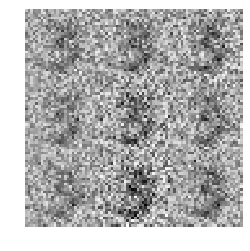

After  20  batches:


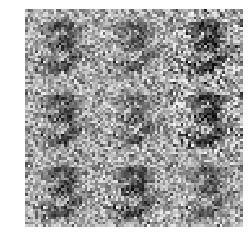

After  30  batches:


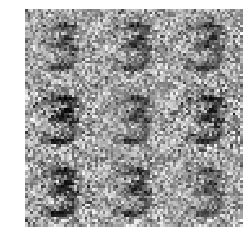

After  40  batches:


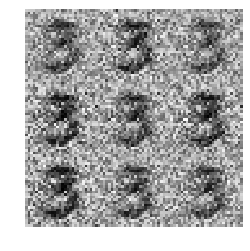

After  50  batches:


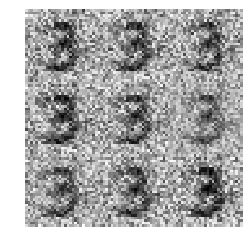

After  60  batches:


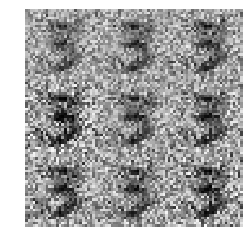

After  70  batches:


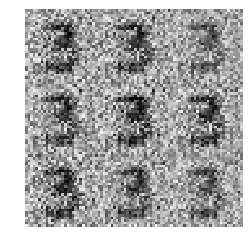

After  80  batches:


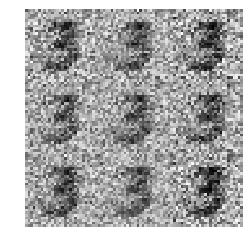

After  90  batches:


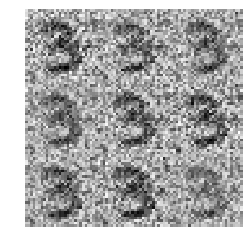

After  100  batches:


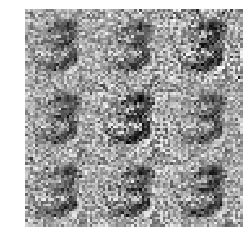

After  110  batches:


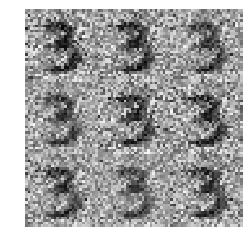

After  120  batches:


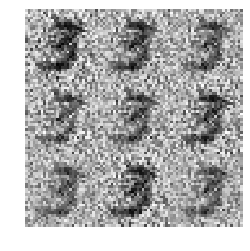

After  130  batches:


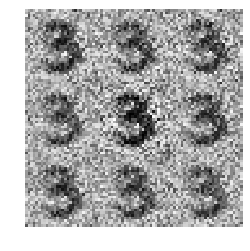

After  140  batches:


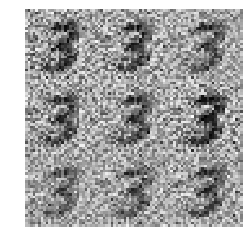

After  150  batches:


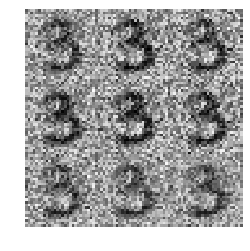

After  160  batches:


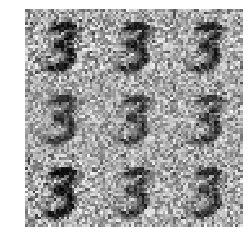

After  170  batches:


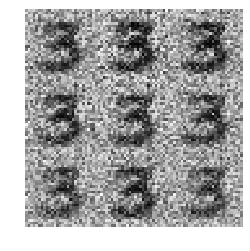

After  180  batches:


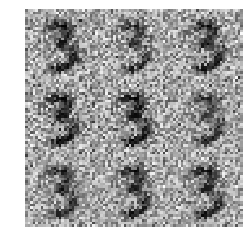

After  190  batches:


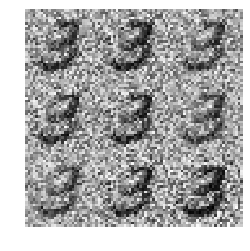

After  200  batches:


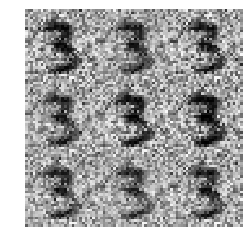

After  210  batches:


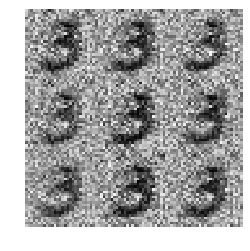

After  220  batches:


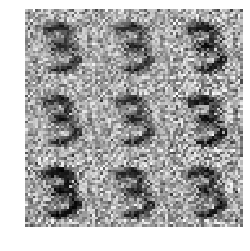

After  230  batches:


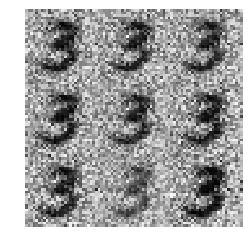

After  240  batches:


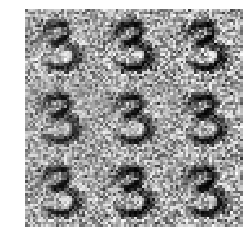

After  250  batches:


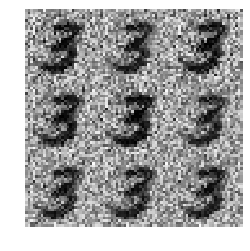

After  260  batches:


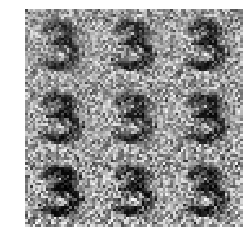

After  270  batches:


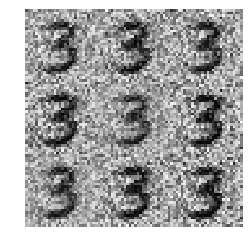

After  280  batches:


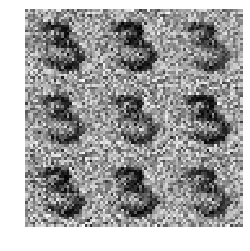

After  290  batches:


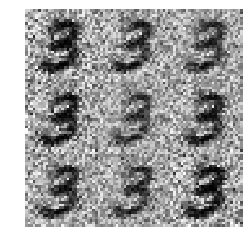

After  300  batches:


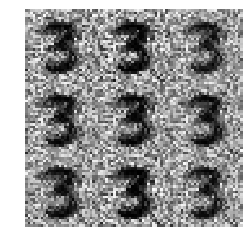

After  310  batches:


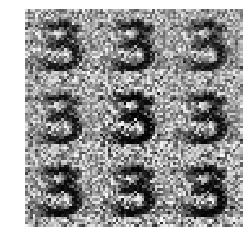

After  320  batches:


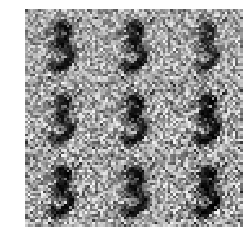

After  330  batches:


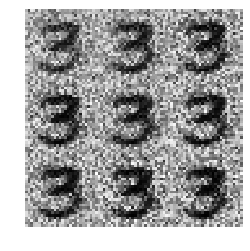

After  340  batches:


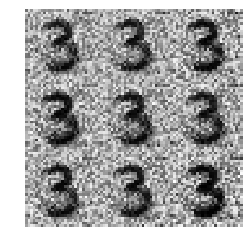

After  350  batches:


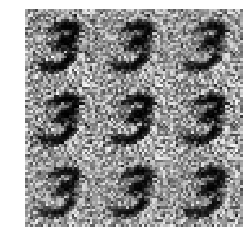

After  360  batches:


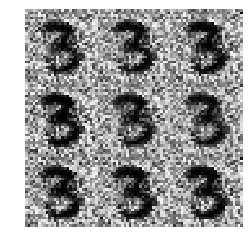

After  370  batches:


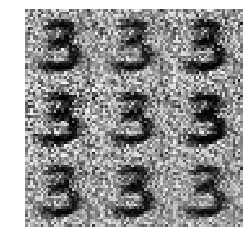

After  380  batches:


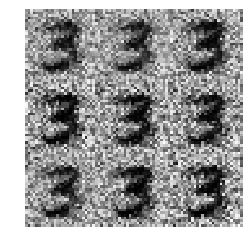

After  390  batches:


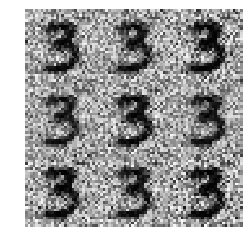

After  400  batches:


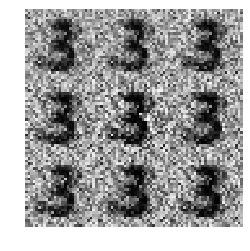

After  410  batches:


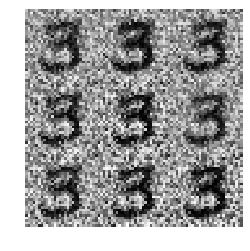

After  420  batches:


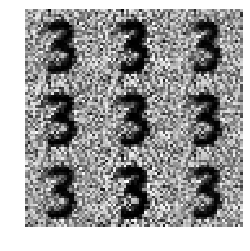

After  430  batches:


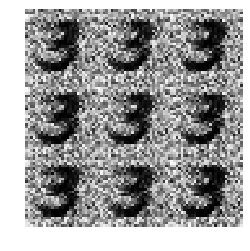

After  440  batches:


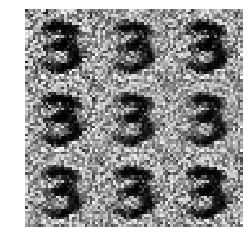

After  450  batches:


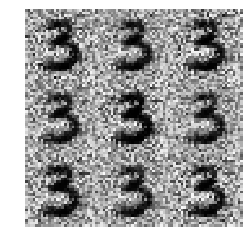

After  460  batches:


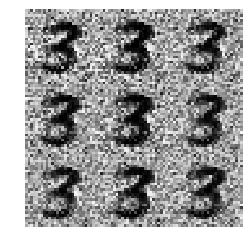

After  470  batches:


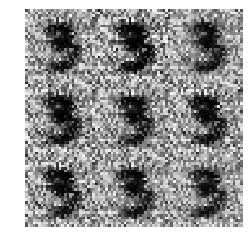

After  480  batches:


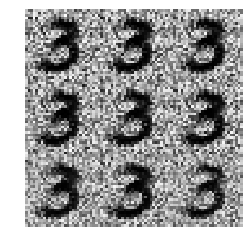

After  490  batches:


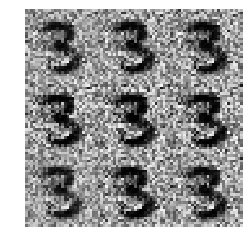

After  500  batches:


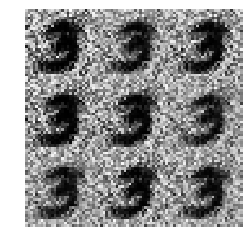

[]

In [12]:
train(500)



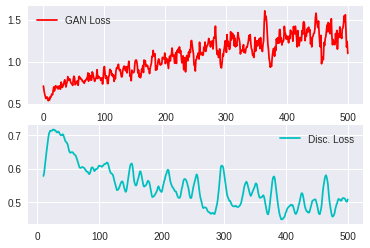

In [13]:
plot_progress()

## Summary

A simple generative adversarial network was successfully trained to draw a single digit.   The network learned very quickly, drawing clear digits in fewer than 10 batches.
